# **KomuterPulse Model Development: Random Forest for Ridership Prediction**
This notebook focuses on developing machine learning models for our KomuterPulse project, with special emphasis on Random Forest Regressor for ridership prediction. The model will leverage engineered features from our KTM Komuter transit data to forecast hourly ridership between station pairs.


### **Objectives**
1. Load and prepare the feature-engineered data
2. Build and train Random Forest models
3. Evaluate model performance using RMSE and MAE
4. Save the trained model for later use

Let's start by importing the necessary libraries and loading our preprocessed data.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from pathlib import Path
from datetime import datetime
import time

# For data preprocessing and scaling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# For visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Set random seeds for reproducibility
np.random.seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## **Data Loading and Preparation**

First, let's load the preprocessed and feature-engineered data along with the feature subsets identified in the feature engineering notebook.

This section is critical for setting up our model training. We will load the data that has already undergone significant processing and feature engineering, including the creation of time-series related features like lags and rolling statistics.

**Key steps in this data preparation phase include:**

1.  **Loading Data:** We prioritize loading from efficient formats like Parquet if available, falling back to CSV if necessary. This is important for handling potentially large datasets. We also load pre-identified feature subsets.

2.  **Handling Time-Series Gaps:** Time-series data often has missing timestamps. We will reindex the data per route to a complete hourly sequence and carefully impute missing ridership values and other numerical features to ensure continuous sequences for time-series feature calculations.

3.  **Recalculating Time-Series Features:** To prevent data leakage, we recalculate time-series features (lags, rolling means, etc.) *strictly within each route group* and using only *past* data at each timestamp. Any potentially "leaky" features calculated globally or with future data will be explicitly removed.

4.  **Feature Selection and Preparation:** We identify the final set of numerical features to be used for training, including the target variable (`total_ridership`) and relevant engineered features. We handle any remaining missing values by imputing using training data statistics.

5.  **Data Validation:** We perform basic checks on column names, data types, and missing values to ensure the data is in the expected format before proceeding to model training.

In [22]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
DATA_DIR = Path('/content/drive/MyDrive/komuter')
train_path = DATA_DIR / 'komuter_train.csv'
test_path = DATA_DIR / 'komuter_test.csv'
feature_subsets_path = DATA_DIR / 'feature_subsets.pkl'

# Define paths for processed data
processed_train_path = DATA_DIR / 'komuter_train_processed.parquet' # Using parquet for efficiency
processed_test_path = DATA_DIR / 'komuter_test_processed.parquet'   # Using parquet for efficiency

# Check if processed files already exist
if processed_train_path.exists() and processed_test_path.exists():
    print("Processed data files found. Loading from disk.")
    try:
        train_df = pd.read_parquet(processed_train_path)
        test_df = pd.read_parquet(processed_test_path)
        print(f"Processed training data loaded: {train_df.shape}")
        print(f"Processed testing data loaded: {test_df.shape}")

        # Ensure 'date' column is datetime after loading from parquet
        # Parquet often preserves types, but verify.
        if not pd.api.types.is_datetime64_any_dtype(train_df['date']):
             train_df['date'] = pd.to_datetime(train_df['date'])
        if not pd.api.types.is_datetime64_any_dtype(test_df['date']):
             test_df['date'] = pd.to_datetime(test_df['date'])

        # Load feature subsets
        try:
            with open(feature_subsets_path, 'rb') as f:
                feature_subsets = pickle.load(f)
            print("Feature subsets loaded successfully.")
        except FileNotFoundError:
            print(f"Warning: {feature_subsets_path} not found.")
            feature_subsets = {} # Initialize empty if file not found

    except Exception as e:
        print(f"Error loading processed files: {e}")
        print("Attempting to re-process data from original CSVs.")
        # Fall through to processing section if loading fails

else:
    print("Processed data files not found or incomplete. Processing from original CSVs.")


# Load data
try:
    # Ensure date column is parsed as datetime immediately
    train_df = pd.read_csv(train_path, parse_dates=['date'])
    test_df = pd.read_csv(test_path, parse_dates=['date'])
    print(f"Training data loaded: {train_df.shape}")
    print(f"Testing data loaded: {test_df.shape}")

    # Load feature subsets
    with open(feature_subsets_path, 'rb') as f:
        feature_subsets = pickle.load(f)
    print("Feature subsets loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure data files are in correct location.")

# Identify columns that look like lag or rolling features based on naming convention
cols_to_drop_pattern = r'_(lag|mean|max|min|std)_.*h$|ridership_diff_.*|ridership_pct_change_.*'
cols_to_drop = [col for col in train_df.columns if pd.Series(col).str.contains(cols_to_drop_pattern).any()] # Check both dataframes

# Also explicitly drop the known leaky ones if their names don't match the pattern
leaky_non_pattern_cols = ['max_ridership', 'avg_ridership', 'min_ridership']
cols_to_drop.extend(leaky_non_pattern_cols)

# Drop duplicates just to be safe
cols_to_drop = list(set(cols_to_drop))

print(f"\nDropping potentially leaky pre-calculated columns: {cols_to_drop}")
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')

print(f"Training data shape after dropping leaky columns: {train_df.shape}")
print(f"Testing data shape after dropping leaky columns: {test_df.shape}")

# Define parameters for time-series features
lags = [1, 2, 3, 6, 12, 24, 168]
rolling_windows = [3, 6, 12, 24]
diff_periods = [1, 2, 3, 6, 12, 24, 168]
pct_change_periods = [24, 168] # Daily and Weekly changes

# Sort dataframes by route, date, and hour
train_df = train_df.sort_values(by=['route', 'date', 'hour'])
test_df = test_df.sort_values(by=['route', 'date', 'hour'])

print("\nProcessing data and recalculating time-series features strictly per route...")

# Function to process each route group: reindex and calculate features
def process_route_group(df_group):
    # Ensure the group is sorted by date and hour
    df_group = df_group.sort_values(by=['date', 'hour'])

    # --- Step 1: Reindex to a complete hourly sequence for this route ---
    # Create a full date_time index for this route group
    if df_group.empty:
            return df_group

    min_date_time = datetime.combine(df_group['date'].min(), datetime.min.time().replace(hour=df_group['hour'].min()))
    max_date_time = datetime.combine(df_group['date'].max(), datetime.min.time().replace(hour=df_group['hour'].max()))

    # Avoid creating index if start > end
    if min_date_time > max_date_time:
          print(f"Warning: Min date/time ({min_date_time}) > Max date/time ({max_date_time}) for group. Skipping reindex.")
          # Fallback: just return the original sorted group for feature calc
          df_group['date_time'] = pd.to_datetime(df_group['date'].astype(str) + ' ' + df_group['hour'].astype(str) + ':00:00')
          return df_group

    # Create a full hourly range
    full_time_index = pd.date_range(start=min_date_time, end=max_date_time, freq='H')

    # Set the current date and hour columns as a temporary DatetimeIndex
    df_group['date_time'] = pd.to_datetime(df_group['date'].astype(str) + ' ' + df_group['hour'].astype(str) + ':00:00')
    df_group = df_group.set_index('date_time')

    # Reindex the group using the full time index
    # This will introduce rows with NaN for missing hours
    df_group_reindexed = df_group.reindex(full_time_index)

    # --- Step 2: Impute missing values introduced by reindexing ---
    # Reindex will create NaNs for ALL columns. We need to handle this.
    # Columns like 'route', 'station_name', etc. should be filled
    # 'total_ridership' and numerical features need imputation
    # The 'hour' column needs to be recalculated from the new index

    # Recalculate 'hour' and 'date' from the new index
    df_group_reindexed['hour'] = df_group_reindexed.index.hour
    df_group_reindexed['date'] = df_group_reindexed.index.date

    # Fill static/categorical columns (like route)
    for col in ['route', 'start_station', 'end_station']:
         if col in df_group_reindexed.columns:
              df_group_reindexed[col] = df_group_reindexed[col].fillna(method='ffill').fillna(method='bfill') # Fill NaNs at start/end too

    # Impute 'total_ridership' and other numerical features
    if 'total_ridership' in df_group_reindexed.columns:
         df_group_reindexed['total_ridership'] = df_group_reindexed['total_ridership'].interpolate(method='linear')
         df_group_reindexed['total_ridership'] = df_group_reindexed['total_ridership'].fillna(method='ffill').fillna(method='bfill')
         df_group_reindexed['total_ridership'] = df_group_reindexed['total_ridership'].fillna(0) # Final fallback to 0 if no data existed

    # Impute other numerical features that were not original time-series calcs
    # For other original features that got NaNs from reindexing, interpolate or fill with median from original group
    original_numerical_cols = df_group.select_dtypes(include=np.number).columns.tolist()
    cols_to_impute_interp = [col for col in original_numerical_cols if col not in ['hour', 'total_ridership']] # Avoid re-imputing hour/ridership
    for col in cols_to_impute_interp:
         if col in df_group_reindexed.columns:
              df_group_reindexed[col] = df_group_reindexed[col].interpolate(method='linear')
              df_group_reindexed[col] = df_group_reindexed[col].fillna(method='ffill').fillna(method='bfill')

    # --- Step 3: Recalculate time-series features on the reindexed data ---
    # Ensure the data is sorted by the new datetime index for correct calculations
    df_group_reindexed = df_group_reindexed.sort_index()

    # Calculate Lag Features
    if 'total_ridership' in df_group_reindexed.columns:
         for lag in lags:
             # Using .shift() on a DatetimeIndex respects missing timestamps correctly IF freq is set on index
             # Since we reindexed with freq='H', shift(1) means shifting by 1 hour, shift(24) by 24 hours etc.
             # However, shift *within the DataFrame index* is safer than relying on row index
             df_group_reindexed[f'total_ridership_lag_{lag}h'] = df_group_reindexed['total_ridership'].shift(freq=f'{lag}H')

         # Calculate Rolling Features
         # Use closed='left' to ensure only PAST data is used for the window ending at the current point
         # min_periods=1 allows calculation even with fewer points than the window size at the start
         for window in rolling_windows:
             # Rolling on a DatetimeIndex with a time window (e.g., '3H' for 3 hours)
             df_group_reindexed[f'rolling_mean_{window}h'] = df_group_reindexed['total_ridership'].rolling(window=f'{window}H', min_periods=1, closed='left').mean()
             df_group_reindexed[f'rolling_max_{window}h'] = df_group_reindexed['total_ridership'].rolling(window=f'{window}H', min_periods=1, closed='left').max()
             df_group_reindexed[f'rolling_min_{window}h'] = df_group_reindexed['total_ridership'].rolling(window=f'{window}H', min_periods=1, closed='left').min()
             df_group_reindexed[f'rolling_std_{window}h'] = df_group_reindexed['total_ridership'].rolling(window=f'{window}H', min_periods=1, closed='left').std(ddof=1)
             df_group_reindexed[f'rolling_std_{window}h'] = df_group_reindexed[f'rolling_std_{window}h'].fillna(0)

         # Difference Features
         for period in diff_periods:
             # diff(periods=...) on a DatetimeIndex with freq uses the frequency
             df_group_reindexed[f'ridership_diff_{period}h'] = df_group_reindexed['total_ridership'].diff(periods=period) # periods=1 means difference between consecutive index points (hours)

         # Percent Change Features
         for period in pct_change_periods:
              # pct_change(periods=...) on a DatetimeIndex with freq uses the frequency
              # Handle division by zero/nan as before
              df_group_reindexed[f'ridership_pct_change_{period}h'] = df_group_reindexed['total_ridership'].replace(0, np.nan).pct_change(periods=period)
              df_group_reindexed[f'ridership_pct_change_{period}h'] = df_group_reindexed[f'ridership_pct_change_{period}h'].replace([np.inf, -np.inf], np.nan)

    # Reset the index and handle the date_time column
    df_group_reindexed = df_group_reindexed.reset_index()
    df_group_reindexed = df_group_reindexed.rename(columns={'index': 'date_time'})

    # Convert date_time back to date object for the 'date' column
    df_group_reindexed['date'] = df_group_reindexed['date_time'].dt.date

    return df_group_reindexed

    # Apply processing grouped by route and concatenate
    print("Processing training data by route...")
    start_time = time.time()
    train_list = []
    for _, group in train_df.groupby('route'):
        train_list.append(process_route_group(group))
    train_df_processed = pd.concat(train_list, ignore_index=True)
    end_time = time.time()
    print(f"Training data processing complete in {end_time - start_time:.2f} seconds. Shape: {train_df_processed.shape}")

    # Save the processed training data
    print(f"Saving processed training data to {processed_train_path}...")
    train_df_processed.to_parquet(processed_train_path, index=False)
    print("Processed training data saved.")

    # Clear training data from memory to free up space before processing test data
    del train_df, train_list
    import gc
    gc.collect()
    print("Training data cleared from memory.")

    print("Processing test data by route...")
    start_time = time.time()
    test_list = []
    for _, group in test_df.groupby('route'):
        test_list.append(process_route_group(group))
    test_df_processed = pd.concat(test_list, ignore_index=True)
    end_time = time.time()
    print(f"Test data processing complete in {end_time - start_time:.2f} seconds. Shape: {test_df_processed.shape}")

    # Save the processed test data
    print(f"Saving processed test data to {processed_test_path}...")
    test_df_processed.to_parquet(processed_test_path, index=False)
    print("Processed test data saved.")

    # Clear original test data from memory
    del test_df, test_list
    gc.collect()
    print("Test data cleared from memory.")


    # Now load the saved processed data back for consistency and to ensure memory is clean
    print("Loading processed data from saved files...")
    train_df = pd.read_parquet(processed_train_path)
    test_df = pd.read_parquet(processed_test_path)
    print(f"Processed training data reloaded: {train_df.shape}")
    print(f"Processed testing data reloaded: {test_df.shape}")

    # Ensure 'date' column is datetime after loading from parquet if needed
    if not pd.api.types.is_datetime64_any_dtype(train_df['date']):
         train_df['date'] = pd.to_datetime(train_df['date'])
    if not pd.api.types.is_datetime64_any_dtype(test_df['date']):
         test_df['date'] = pd.to_datetime(test_df['date'])

# Drop the temporary 'date_time' column if it was created and not needed as a feature
if 'date_time' in train_df.columns:
    train_df = train_df.drop(columns=['date_time'])
if 'date_time' in test_df.columns:
    test_df = test_df.drop(columns=['date_time'])


print(f"Training data shape after processing: {train_df.shape}")
print(f"Testing data shape after processing: {test_df.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processed data files not found or incomplete. Processing from original CSVs.
Training data loaded: (537642, 55)
Testing data loaded: (132957, 55)
Feature subsets loaded successfully.

Dropping potentially leaky pre-calculated columns: ['rolling_max_3h', 'total_ridership_lag_12h', 'total_ridership_lag_1h', 'rolling_mean_6h', 'ridership_pct_change_1d', 'total_ridership_lag_24h', 'rolling_mean_12h', 'rolling_min_24h', 'ridership_pct_change_1w', 'rolling_std_3h', 'rolling_std_24h', 'rolling_mean_3h', 'rolling_max_12h', 'ridership_diff_1h', 'ridership_diff_1w', 'rolling_std_6h', 'ridership_diff_2h', 'total_ridership_lag_2h', 'rolling_max_6h', 'rolling_min_6h', 'max_ridership', 'min_ridership', 'rolling_max_24h', 'ridership_diff_1d', 'total_ridership_lag_6h', 'rolling_min_12h', 'avg_ridership', 'ridership_pct_change_1h', 'total_ridership_lag_3h', 'rolling_std_12h',

## **Feature Selection and Final Data Preparation**

Following the data loading and processing, we now define the target variable, select the features to be used for training the Random Forest model, and prepare the final input data (`X`) and target (`y`) sets. This includes handling the encoding of the route identifier and ensuring that potentially leaky features are excluded.


In [23]:
# Define target variable *before* using it in feature selection
target_col = 'total_ridership'

# Display the available feature subsets and their sizes
for subset_name, features in feature_subsets.items():
    if isinstance(features, list):
        print(f"{subset_name}: {len(features)} features")
    else:
        print(f"{subset_name}: {features}")

# Identify all feature columns *after* recalculation
# Exclude target, date, hour, route identifier columns that are not features
identifier_cols = ['route', 'date', 'hour', 'route_id']
all_calculated_cols = [col for col in train_df.columns if col not in identifier_cols + [target_col]]

selected_features = all_calculated_cols

# Ensure 'route_id' is included
print("\nRe-encoding 'route_id'...")
# Get categories from train *before* encoding test
train_routes = train_df['route'].astype('category').cat.categories
train_df['route_id'] = train_df['route'].astype('category').cat.codes
# Use categories from train for test to ensure consistency
test_df['route_id'] = test_df['route'].astype('category').cat.set_categories(train_routes).cat.codes

if 'route_id' not in selected_features:
     selected_features.append('route_id')

# Remove potentially problematic features - Start with the obvious leakage sources
features_to_remove = [
    target_col,         # Should never be a feature if it's the target
    'target',           # Also the target
    'max_ridership',    # Found to be identical/proxy to target
    'avg_ridership',    # Found to be identical/proxy to target
    'min_ridership'     # Found to be identical/proxy to target
]
selected_features = [f for f in selected_features if f not in features_to_remove]
selected_features = list(set(selected_features)) # Remove any potential duplicates

print(f"\nSelected features for Random Forest model ({len(selected_features)} features):")
print(selected_features)


all_features: 53 features
consensus_features: 18 features
rf_top_features: 15 features
xgb_top_features: 15 features
selectkbest_features: 20 features
pca_n_components: 19

Re-encoding 'route_id'...

Selected features for Random Forest model (21 features):
['route_id', 'hour_of_day', 'is_peak_evening', 'total_ridership_lag_1w', 'destination', 'day_of_week', 'hour_sin', 'day_of_week_sin', 'destination_popularity', 'day_of_week_cos', 'is_peak_morning', 'is_statistical_outlier', 'hour_cos', 'origin', 'origin_popularity', 'rolling_dow_mean', 'is_route_outlier', 'is_business_hours', 'is_night_hours', 'is_weekend', 'is_rush_hour']


## **Data Validation and Final Input Preparation**

In the previous step, we identified a comprehensive list of potential features. This section performs final checks and finalizes the input data for our Random Forest model. This includes:

1.  Verifying the completeness of our selected features by checking for missing values in both the training and test sets.
2.  Applying robust imputation techniques to handle any detected missing data, ensuring no information from the test set is used in training data imputation.
3.  Confirming that the selected features have the correct data types expected by the model.
4.  Structuring the data into the standard `X` (features) and `y` (target) arrays for both the training and testing phases.

In [24]:
# Check the first few rows of the training data
train_df.head()


,route,date,hour,total_ridership,day_of_week,is_weekend,origin,destination,origin_popularity,destination_popularity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,total_ridership_lag_1w,rolling_dow_mean,hour_of_day,is_rush_hour,is_peak_morning,is_peak_evening,is_business_hours,is_night_hours,is_statistical_outlier,is_route_outlier,route_id
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,4,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,0.866025,-0.433884,-0.900969,0.0,2.000000,22,False,False,False,False,True,False,False,0
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,6,True,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,-0.866025,-0.781831,0.623490,0.0,1.500000,14,False,False,False,False,False,False,False,0
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,0,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.000000,1.000000,0.0,1.666667,19,True,False,True,False,False,False,False,0
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.866025,-0.500000,0.781831,0.623490,0.0,1.500000,16,False,False,False,True,False,False,False,0
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.781831,0.623490,0.0,1.400000,19,True,False,True,False,False,False,False,0


In [25]:
# Check if we have any missing values
print(f"Missing values in training data before imputation: {train_df[selected_features].isnull().sum().sum()}")
print(f"Missing values in test data before imputation: {test_df[selected_features].isnull().sum().sum()}")

# Identify numeric columns within the selected features
numeric_features = train_df[selected_features].select_dtypes(include=np.number).columns.tolist()
print(f"\nIdentifying numeric features within selected_features for imputation ({len(numeric_features)} features):")
print(numeric_features)

# Calculate imputation values (e.g., median) ONLY from the training data
imputation_values = train_df[numeric_features].median()
print("\nImputation values calculated from Training Data median:")
print(imputation_values)

# Fill missing values in BOTH train_df and test_df using the imputation values from the training data
train_df[numeric_features] = train_df[numeric_features].fillna(imputation_values)
test_df[numeric_features] = test_df[numeric_features].fillna(imputation_values)

# Verify no more missing values in selected features
print(f"\nMissing values in training data after imputation: {train_df[numeric_features].isnull().sum().sum()}")
print(f"Missing values in test data after imputation: {test_df[numeric_features].isnull().sum().sum()}")

# Check missing values in the full selected_features list (including non-numeric)
# This is just for verification; non-numeric columns might still have NaNs if not handled elsewhere.
print(f"\nMissing values in training data (all selected features) after numeric imputation: {train_df[selected_features].isnull().sum().sum()}")
print(f"Missing values in test data (all selected features) after numeric imputation: {test_df[selected_features].isnull().sum().sum()}")

# Create the target variable for Random Forest
train_df['target'] = train_df[target_col]
test_df['target'] = test_df[target_col]

# Identify non-numeric columns within selected_features
non_numeric_features = train_df[selected_features].select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNon-numeric features found in selected_features ({len(non_numeric_features)} features):")
print(non_numeric_features)

# Filter selected_features to keep only numeric columns (including 'route_id' which is already numeric code)
# Assuming 'route_id' is the only intended non-original-numeric feature included via encoding
final_selected_features = [f for f in selected_features if f in numeric_features or f == 'route_id']

print(f"\nFinal features for Random Forest model after filtering non-numeric ({len(final_selected_features)} features):")
print(final_selected_features)

# Create the feature matrix (X) and target vector (y) for both train and test sets
X_train = train_df[final_selected_features]
y_train = train_df['target']
X_test = test_df[final_selected_features]
y_test = test_df['target']

# VERIFICATION STEP: Check dtypes of X_train and X_test before training
print("\nData types of X_train before fitting model:")
print(X_train.dtypes)

print("\nData types of X_test before fitting model:")
print(X_test.dtypes)

# Display the shape of the data
print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Print the list of final selected features
print(f"\nFinal Selected features for Random Forest model ({len(final_selected_features)} features):")
print(final_selected_features)


Missing values in training data before imputation: 0
Missing values in test data before imputation: 0

Identifying numeric features within selected_features for imputation (11 features):
['route_id', 'hour_of_day', 'total_ridership_lag_1w', 'day_of_week', 'hour_sin', 'day_of_week_sin', 'destination_popularity', 'day_of_week_cos', 'hour_cos', 'origin_popularity', 'rolling_dow_mean']

Imputation values calculated from Training Data median:
route_id                  1398.000000
hour_of_day                 14.000000
total_ridership_lag_1w       1.000000
day_of_week                  3.000000
hour_sin                    -0.500000
day_of_week_sin              0.000000
destination_popularity       0.112440
day_of_week_cos             -0.222521
hour_cos                    -0.258819
origin_popularity            0.099701
rolling_dow_mean             2.845238
dtype: float64

Missing values in training data after imputation: 0
Missing values in test data after imputation: 0

Missing values in train

## **Random Forest Model Development**
Now, we shall build and train our Random Forest model for ridership prediction, starting off with a basic model.

### **Basic Random Forest Model Training**
Let's start with the basic Random Forest model and evaluate its performance.

Training MAE: 0.80
Training RMSE: 2.19
Training R² Score: 0.9628


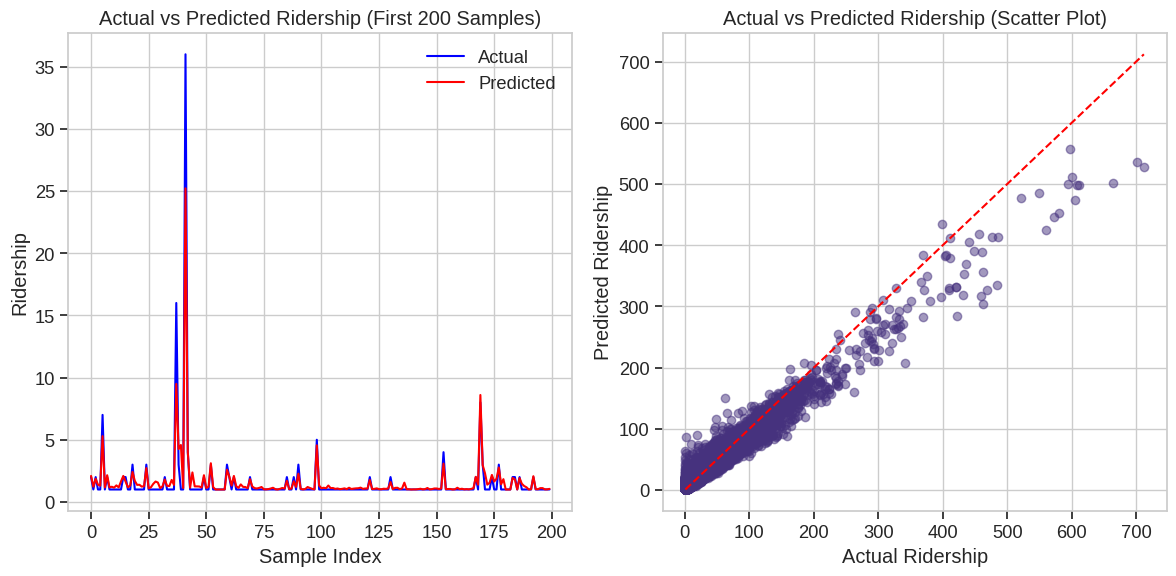

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Print the model's performance on the training set
train_preds = rf_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

print(f"Training MAE: {train_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training R² Score: {train_r2:.4f}")

# Get predictions
train_preds = rf_model.predict(X_train)

plt.figure(figsize=(12, 6))

# Actual vs Predicted - First 200 samples (Line plot)
plt.subplot(1, 2, 1)
plt.plot(y_train.values[:200], label='Actual', color='blue')
plt.plot(train_preds[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)

# Actual vs Predicted - Scatter plot (Training set)
plt.subplot(1, 2, 2)
plt.scatter(y_train, train_preds, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)

plt.tight_layout()
plt.show()


### **Diagnostic Steps for Suspected Data Leakage**
Given extremely high training performance, we need to rigorously check for data leakage. In this section, we will perform several diagnostic checks to identify the source of any leakage. These steps aim to pinpoint any features or data processing steps that might have introduced leakage and help us refine the data preparation process if necessary.

1.  **Feature Inspection**

  We will re-examine the list of selected features to ensure no obvious target-related or future-dated columns were mistakenly included.

In [27]:
# Check 1: Print selected features again
print("\nSelected features being used (post-removal attempt):")
print(selected_features)
# Verify total_ridership, target, max_ridership, avg_ridership, min_ridership are NOT in this list.



Selected features being used (post-removal attempt):
['route_id', 'hour_of_day', 'is_peak_evening', 'total_ridership_lag_1w', 'destination', 'day_of_week', 'hour_sin', 'day_of_week_sin', 'destination_popularity', 'day_of_week_cos', 'is_peak_morning', 'is_statistical_outlier', 'hour_cos', 'origin', 'origin_popularity', 'rolling_dow_mean', 'is_route_outlier', 'is_business_hours', 'is_night_hours', 'is_weekend', 'is_rush_hour']


2.  **Correlation Analysis**

  We will calculate the correlation between the target variable and all features in the training set. Features with extremely high correlation (near 1.0) might be direct proxies for the target or derived from it in a way that introduces leakage.

In [28]:
# Check 2: Calculate correlation between target and all features in X_train
print("\nCorrelation matrix between y_train and X_train features (Absolute values):")
# Ensure X_train and y_train are aligned
correlation_with_target = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print(correlation_with_target)

# Look closely at values above 0.9 or 0.95. Identify the top features.
# Features that are not direct duplicates but have near-perfect correlation might still be proxies for the target.



Correlation matrix between y_train and X_train features (Absolute values):
rolling_dow_mean          0.527641
total_ridership_lag_1w    0.261954
destination_popularity    0.167797
origin_popularity         0.155342
route_id                  0.059705
day_of_week               0.052905
day_of_week_sin           0.048548
hour_of_day               0.017074
hour_sin                  0.014164
hour_cos                  0.008090
day_of_week_cos           0.007301
dtype: float64


3.  **Value Inspection for Highly Correlated Features**

  For features showing suspicious correlations, we will manually inspect their values alongside the target variable for the first few rows to understand the relationship and confirm if they appear to contain leaked information.

In [29]:
# Check 3: Inspect values for the top 3-5 highly correlated features vs target
# Replace 'suspect_feature_name' with the actual names from the correlation list

suspect_features_to_inspect = correlation_with_target.head(5).index.tolist() # Inspect top 5

for suspect_feature_name in suspect_features_to_inspect:
    if suspect_feature_name == 'target': # Skip the target itself
        continue
    print(f"\nInspecting values for '{suspect_feature_name}' vs 'target':")
    # Display first 50 rows side-by-side
    display(pd.concat([X_train[suspect_feature_name].rename(suspect_feature_name),
                       y_train.rename('target')], axis=1).head(50))



Inspecting values for 'rolling_dow_mean' vs 'target':


,rolling_dow_mean,target
0,2.000000,2
1,1.500000,1
2,1.666667,2
3,1.500000,1
4,1.400000,1
5,2.333333,7
6,2.142857,1
7,2.125000,2
8,2.000000,1
9,1.900000,1



Inspecting values for 'total_ridership_lag_1w' vs 'target':


,total_ridership_lag_1w,target
0,0.0,2
1,0.0,1
2,0.0,2
3,0.0,1
4,0.0,1
5,0.0,7
6,0.0,1
7,0.0,2
8,0.0,1
9,0.0,1



Inspecting values for 'destination_popularity' vs 'target':


,destination_popularity,target
0,0.080192,2
1,0.080192,1
2,0.080192,2
3,0.080192,1
4,0.080192,1
5,0.080192,7
6,0.080192,1
7,0.080192,2
8,0.080192,1
9,0.080192,1



Inspecting values for 'origin_popularity' vs 'target':


,origin_popularity,target
0,0.065047,2
1,0.065047,1
2,0.065047,2
3,0.065047,1
4,0.065047,1
5,0.065047,7
6,0.065047,1
7,0.065047,2
8,0.065047,1
9,0.065047,1



Inspecting values for 'route_id' vs 'target':


,route_id,target
0,0,2
1,0,1
2,0,2
3,0,1
4,0,1
5,0,7
6,0,1
7,0,2
8,0,1
9,0,1


4.  **Time-Series Feature Verification**

  We will specifically inspect the calculated lag and rolling features, especially at the beginning of time series for specific routes, to ensure they are correctly calculated using only past data and that initial values reflect the expected lag/window behavior.

In [30]:
# Check 4: Manually inspect lag and rolling features again, focusing on beginnings of groups
# Ensure that at hour H, a K-hour lag feature uses data from H-K, and a K-hour rolling feature
# uses data from H-K up to H-1 (due to closed='left'). Values for early hours in a group
# (e.g., hour 0, hour 1 for lags > 1) should likely be NaN (or imputed values if already imputed).

print("\n--- Detailed Inspection of Time-Series Features ---")

# Find a route with data for several consecutive hours at the start of its training period
# This helps verify that lags/rolling windows are behaving correctly and generating NaNs as expected initially.
# Group by route and date, count how many hours exist
counts = train_df.groupby(['route', 'date']).size().reset_index(name='count')

# Filter for combinations that appear at the start of the route's data (first few dates)
# and have enough hours (e.g., at least 6 hours to see initial lags/rolling windows fill)
routes_dates_with_enough_data_early = counts[counts['count'] >= 6].groupby('route').head(2)

if not routes_dates_with_enough_data_early.empty:
    # Pick one such combination
    route_sample = routes_dates_with_enough_data_early.iloc[0]['route']
    date_sample = routes_dates_with_enough_data_early.iloc[0]['date']

    print(f"\nInspecting time-series features for Route: {route_sample}, Date: {date_sample}")

    example_train_subset = train_df[(train_df['route'] == route_sample) &
                                    (train_df['date'] == date_sample)].sort_values('hour')

    # Select relevant columns (target, lag 1, rolling features, diff, pct_change)
    ts_cols_to_inspect = [col for col in example_train_subset.columns if any(pattern in col for pattern in ['total_ridership', '_lag_', 'rolling_', 'ridership_diff_', 'ridership_pct_change_'])]
    cols_to_inspect_ordered = ['hour', 'total_ridership'] + sorted([c for c in ts_cols_to_inspect if c not in ['hour', 'total_ridership']])

    if not example_train_subset.empty and any(item in example_train_subset.columns for item in ts_cols_to_inspect):
        print(f"\nFirst 20 hours for Route {route_sample} on {date_sample}:")
        display(example_train_subset[cols_to_inspect_ordered].head(20))

        # Manual Verification Examples:
        print("\nManual Verification Snippets:")
        # Check Lag 1h for a specific hour (e.g., hour 5)
        check_hour_lag = 5
        if check_hour_lag in example_train_subset['hour'].values:
            row_at_hour = example_train_subset[example_train_subset['hour'] == check_hour_lag].iloc[0]
            row_at_prev_hour = example_train_subset[example_train_subset['hour'] == check_hour_lag - 1]
            print(f"- Hour {check_hour_lag}: total_ridership = {row_at_hour['total_ridership']:.2f}, total_ridership_lag_1h = {row_at_hour.get('total_ridership_lag_1h', 'N/A'):.2f}")
            if not row_at_prev_hour.empty:
                 print(f"  total_ridership at Hour {check_hour_lag-1}: {row_at_prev_hour.iloc[0]['total_ridership']:.2f} -> Should match lag_1h at Hour {check_hour_lag}")
            else:
                 print(f"  No data for hour {check_hour_lag-1}, lag_1h should be NaN.")

        # Check Rolling Mean (e.g., 3h) for a specific hour (e.g., hour 5)
        check_hour_rolling = 5
        check_window = 3
        if check_hour_rolling in example_train_subset['hour'].values:
            row_at_hour = example_train_subset[example_train_subset['hour'] == check_hour_rolling].iloc[0]
            # Rolling 3h closed='left' for hour 5 should average ridership from hours 2, 3, 4
            hours_for_rolling = example_train_subset[example_train_subset['hour'].between(check_hour_rolling - check_window, check_hour_rolling - 1)]['total_ridership']
            calculated_rolling_mean = hours_for_rolling.mean()
            print(f"\n- Hour {check_hour_rolling}: total_ridership = {row_at_hour['total_ridership']:.2f}, rolling_mean_{check_window}h = {row_at_hour.get(f'rolling_mean_{check_window}h', 'N/A'):.2f}")
            print(f"  Expected rolling_mean_{check_window}h (mean of hours {check_hour_rolling-check_window}-{check_hour_rolling-1}): {calculated_rolling_mean:.2f}")
            print(f"  Ridership values used for manual check: {hours_for_rolling.tolist()}")

    else:
        print("Not enough data or relevant columns in sample to inspect time-series features.")
else:
     print("Could not find a suitable route/date combination early in the data with enough hours for inspection.")



--- Detailed Inspection of Time-Series Features ---

Inspecting time-series features for Route: Abdullah Hukum → Batu Tiga, Date: 2025-01-02 00:00:00

First 20 hours for Route Abdullah Hukum → Batu Tiga on 2025-01-02 00:00:00:


,hour,total_ridership,rolling_dow_mean,total_ridership_lag_1w
292,9,1,1.000000,0.0
293,11,1,1.000000,0.0
294,12,1,1.000000,0.0
295,13,1,1.000000,0.0
296,16,2,1.100000,0.0
297,18,2,1.181818,0.0
298,22,1,1.166667,0.0



Manual Verification Snippets:


5.  **Data Split Chronology Check**

  We will verify the temporal split of the data, ensuring that the earliest date in the test set for each route is chronologically after the latest date in the training set for that route. Overlapping dates between train and test sets, even for different routes, can also indicate a problem with the splitting strategy.

In [31]:
# Check 5: Verify data split chronology
print("\nVerifying Data Split Chronology:")

# Find the latest date in the training set
latest_train_date = train_df['date'].max()
print(f"Latest date in training data: {latest_train_date}")

# Find the earliest date in the test set
earliest_test_date = test_df['date'].min()
print(f"Earliest date in test data: {earliest_test_date}")

# Check if the earliest test date is after the latest train date
is_strict_chronological = pd.to_datetime(earliest_test_date) > pd.to_datetime(latest_train_date)
print(f"Is earliest test date after latest train date overall? {is_strict_chronological}")

# More detailed check: For each route, is the earliest test date after the latest train date for that route?
train_latest_dates_per_route = train_df.groupby('route')['date'].max()
test_earliest_dates_per_route = test_df.groupby('route')['date'].min()

print("\nVerifying Chronology per Route:")
chronology_ok_per_route = {}
for route in train_latest_dates_per_route.index:
    if route in test_earliest_dates_per_route.index:
        latest_train = pd.to_datetime(train_latest_dates_per_route[route])
        earliest_test = pd.to_datetime(test_earliest_dates_per_route[route])
        chronology_ok_per_route[route] = earliest_test > latest_train
    else:
        # Route only exists in train or test, which is also fine for the split itself
        chronology_ok_per_route[route] = 'N/A (Route not in both sets)'

# Print routes where chronology check failed or N/A
print("Chronology check results (Earliest Test Date > Latest Train Date):")
problem_routes = [route for route, status in chronology_ok_per_route.items() if status is False]
if problem_routes:
    print(f"\nWARNING: Potential chronological overlap or issue in these routes: {problem_routes}")
    print("This could indicate a problem with the train/test split strategy.")
else:
    print("\nChronology check passed for all routes present in both sets.")

# Also check if any route is entirely duplicated or appears in both sets with same dates (unlikely but possible)
overlapping_route_dates = pd.merge(
    train_df[['route', 'date']].drop_duplicates(),
    test_df[['route', 'date']].drop_duplicates(),
    on=['route', 'date']
)
if not overlapping_route_dates.empty:
    print("\nWARNING: Found overlapping route/date combinations between train and test:")
    display(overlapping_route_dates.head())
    print("This is a strong indicator of data leakage due to an incorrect split.")



Verifying Data Split Chronology:
Latest date in training data: 2025-03-29 00:00:00
Earliest date in test data: 2025-03-30 00:00:00
Is earliest test date after latest train date overall? True

Verifying Chronology per Route:
Chronology check results (Earliest Test Date > Latest Train Date):

Chronology check passed for all routes present in both sets.


### **Hyperparameter Tuning**

With the data leakage diagnostics complete and our data preparation validated, we move to the next stage: enhancing the Random Forest model's performance. While the initial training performance was high, the diagnostics helped us confirm the integrity of the data split and feature engineering. Now, to address potential overfitting and improve the model's ability to generalize to new data, we will perform hyperparameter tuning to regularize the model.

In [32]:
# Define hyperparameter space
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up the random search
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=2,
    verbose=2,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

# Run hyperparameter tuning
print("Starting RandomizedSearchCV...")
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
print(f"RandomizedSearchCV finished in {end_time - start_time:.2f} seconds")


# Best model
best_rf_model = random_search.best_estimator_

# Predict on test set
tuned_preds = best_rf_model.predict(X_test)

# Evaluate
tuned_mae = mean_absolute_error(y_test, tuned_preds)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_preds))
tuned_r2 = r2_score(y_test, tuned_preds)

# Print results
print("\nBest Hyperparameters:")
print(random_search.best_params_)
print("\nTuned Model Performance on Test Set:")
print(f"Tuned Test MAE: {tuned_mae:.2f}")
print(f"Tuned Test RMSE: {tuned_rmse:.4f}")
print(f"Tuned Test R² Score: {tuned_r2:.4f}")


Starting RandomizedSearchCV...
Fitting 2 folds for each of 50 candidates, totalling 100 fits
RandomizedSearchCV finished in 7876.44 seconds

Best Hyperparameters:
{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 289}

Tuned Model Performance on Test Set:
Tuned Test MAE: 2.50
Tuned Test RMSE: 6.4308
Tuned Test R² Score: 0.6019


### **Random Forest Model Performance on Test Set**

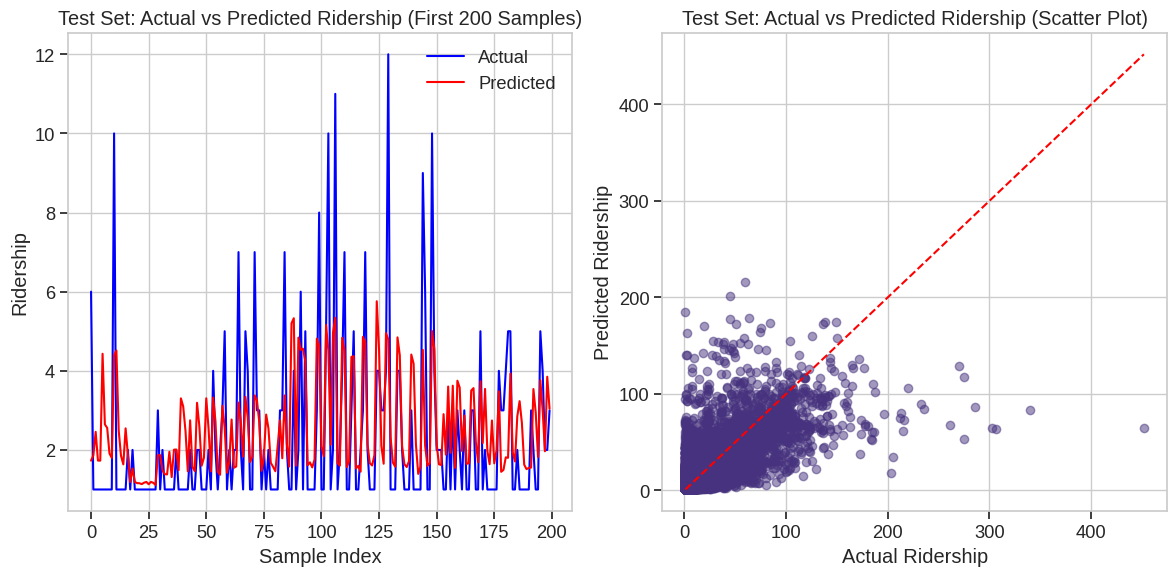

In [33]:
# Print the model's performance on the test set

# Get predictions on test set
test_preds = best_rf_model.predict(X_test)

plt.figure(figsize=(12, 6))

# Actual vs Predicted - First 200 samples (Line plot)
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:200], label='Actual', color='blue')
plt.plot(test_preds[:200], label='Predicted', color='red')
plt.title('Test Set: Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)

# Actual vs Predicted - Scatter plot (Test set)
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Test Set: Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)

plt.tight_layout()
plt.show()


## **Model Saving**
With the Random Forest model trained and evaluated, let's save them for later use. This will allow us to load the model later for making predictions on new data without the need for retraining. We will use the `pickle` library for serialization.


In [34]:
# Define the path to save the model
model_save_path = DATA_DIR / 'random_forest_model.pkl'

print(f"Saving the trained model to {model_save_path}...")

# Use pickle to save the model
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_rf_model, f)
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

# Create a dictionary to store the evaluation results
evaluation_results = {
    'test_mae': tuned_mae,
    'test_rmse': tuned_rmse,
    'test_r2': tuned_r2,
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S") # Add a timestamp
}

# Define the path to save the results
results_save_path = DATA_DIR / 'random_forest_evaluation_results.pkl' # Using .pkl to save the dictionary

print(f"\nSaving evaluation results to {results_save_path}...") # Added newline for separation

# Use pickle to save the dictionary
try:
    with open(results_save_path, 'wb') as f:
        pickle.dump(evaluation_results, f)
    print("Evaluation results saved successfully.")
except Exception as e:
    print(f"Error saving evaluation results: {e}")


# To use the saved model later:
# Mount Google Drive
# drive.mount('/content/drive')

# Define the path to the saved files
# DATA_DIR = Path('/content/drive/MyDrive/komuter') # Make sure this path is correct
# model_load_path = DATA_DIR / 'random_forest_model.pkl'
# results_load_path = DATA_DIR / 'random_forest_evaluation_results.pkl'

# print(f"Loading the trained model from {model_load_path}...")

# Load the model using pickle
# try:
   # with open(model_load_path, 'rb') as f:
       # loaded_model = pickle.load(f)
   # print("Model loaded successfully.")
    # Now you can use loaded_model for predictions
    # predictions = loaded_model.predict(new_data)
# except FileNotFoundError:
   # print(f"Error: Model file not found at {model_load_path}")
# except Exception as e:
   # print(f"Error loading model: {e}")


Saving the trained model to /content/drive/MyDrive/komuter/random_forest_model.pkl...
Model saved successfully.

Saving evaluation results to /content/drive/MyDrive/komuter/random_forest_evaluation_results.pkl...
Evaluation results saved successfully.
